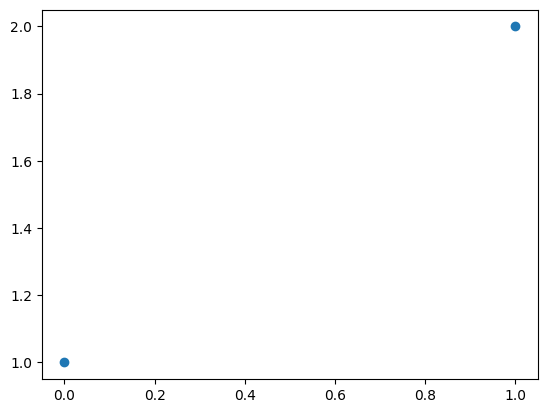

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import seis_test
import cupy as cp
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

10000
Style_A


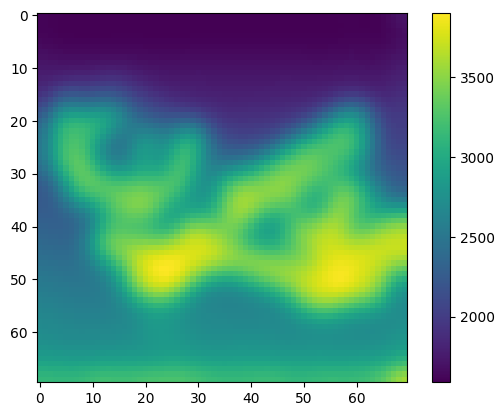

In [2]:
importlib.reload(kgs)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()
d = data[-1001]
print(d.family)
d.load_to_memory()
plt.figure()
plt.imshow(cp.asnumpy(d.velocity.data));plt.colorbar();#plt.clim([-3,3])

In [3]:
# importlib.reload(seis_forward)
# seis_forward.vel_to_seis_J_file(d.velocity, kgs.temp_dir + 'J')

In [4]:
def matmul_efficient(A,B):
    out = cp.zeros((A.shape[0],B.shape[1]), dtype=A.dtype)
    sub_list = np.array_split(np.arange(A.shape[1]), 49)
    for inds in sub_list:
        #print(len(inds))
        out += cp.matmul(A[:,inds],B[inds,:])
    return out
def matmul_part_cpu(A,B):
    out = cp.array(A@cp.asnumpy(B))
    return out
    

In [5]:
# J = cp.zeros((349650,4901),dtype=cp.float32)
# for ind in range(49):
#     J[:,100*ind:100*(ind+1)] = kgs.dill_load(kgs.temp_dir + 'J' + str(ind) + '.pickle')
# ind = 49
# J[:,4900:] = kgs.dill_load(kgs.temp_dir + 'J' + str(ind) + '.pickle')
importlib.reload(seis_forward)
J = seis_forward.vel_to_seis_J_load_file(kgs.temp_dir + 'J_64_', to_cpu=True)

In [6]:
#J = kgs.dill_load(kgs.temp_dir + 'J.pickle', J)
JTJ = cp.array(np.transpose(J)@J)
print(JTJ.dtype)
JTJ = JTJ/2+cp.transpose(JTJ)/2

float64


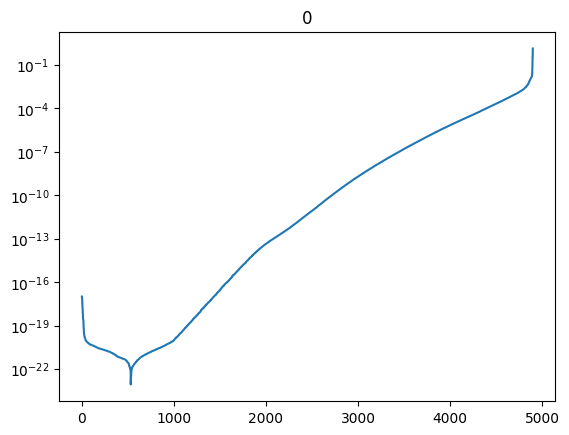

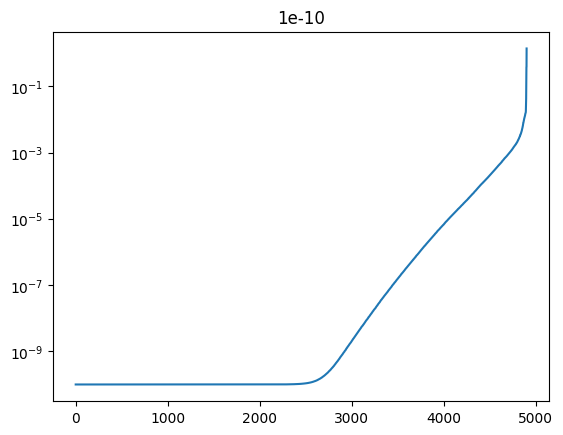

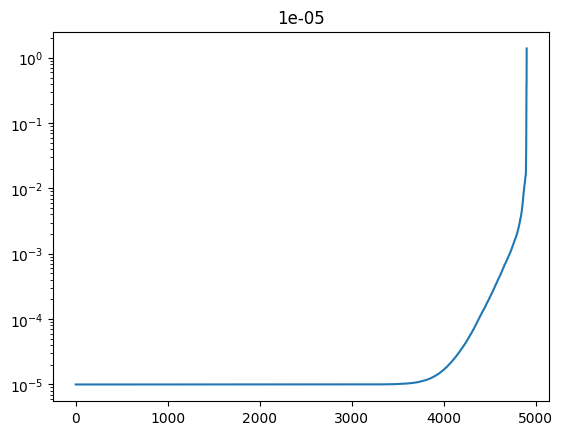

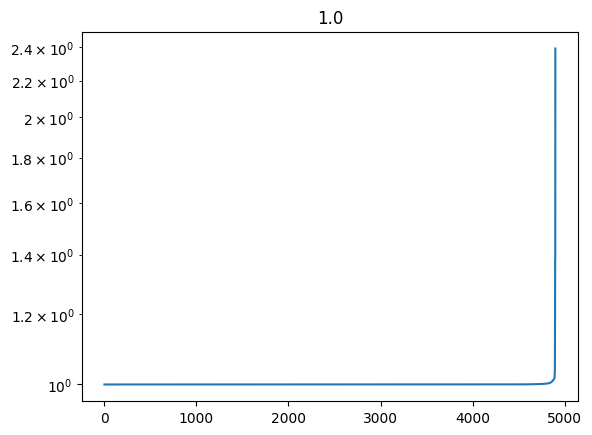

In [7]:
for lam in [0,1e-10,1e-5,1e0]:
    X = lam*cp.eye(4901, dtype=JTJ.dtype)+JTJ
    w = cp.linalg.eigvalsh(X)   
    plt.figure()
    plt.semilogy(cp.asnumpy(cp.abs(w)))
    plt.title(str(lam))

In [150]:
import scipy
basis_vectors = []
for i_row in range(70):
    mat = np.zeros((70,70))
    mat[i_row,:]=1.
    basis_vectors.append(np.concatenate((mat.flatten(), np.array([0]))))
basis_vectors.append(np.concatenate((mat.flatten(), np.array([1]))))
basis_vectors = np.stack(basis_vectors)
basis_vectors = basis_vectors.T
J_basis = cp.array(J@basis_vectors)
basis_vectors=cp.array(basis_vectors)
basis_vectors.shape

(4901, 71)

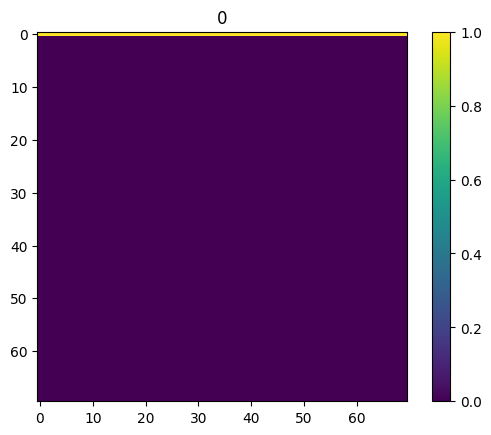

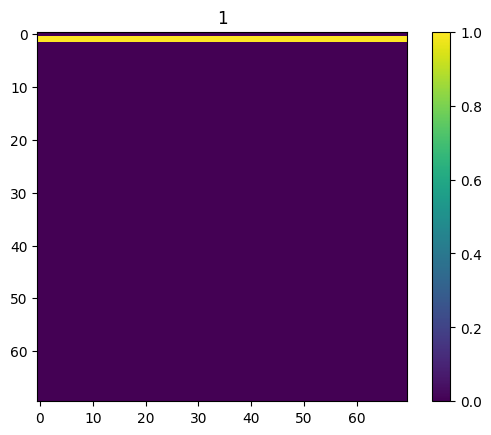

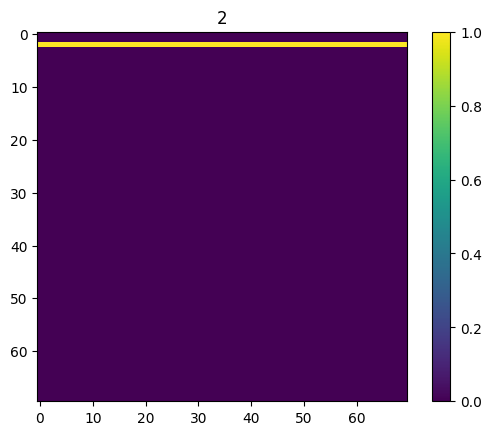

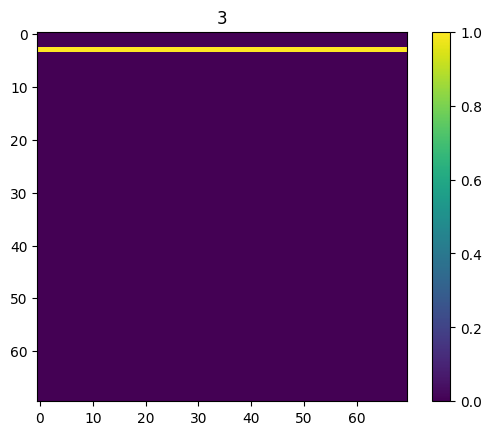

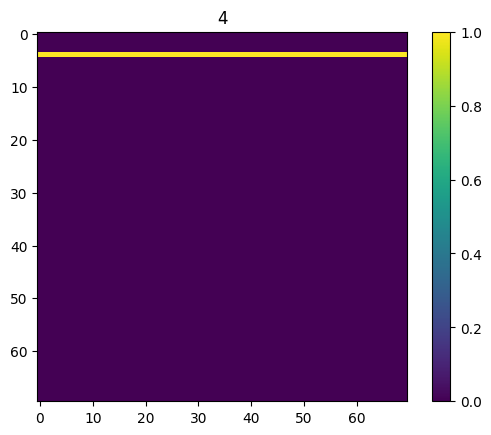

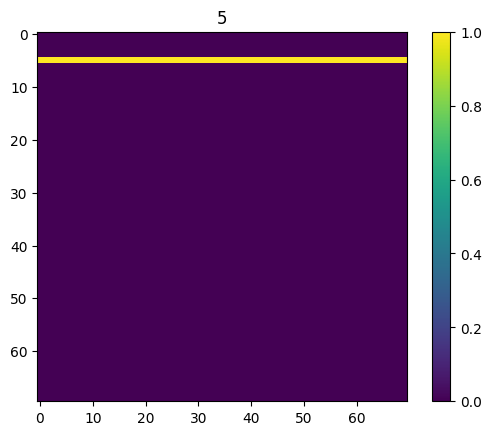

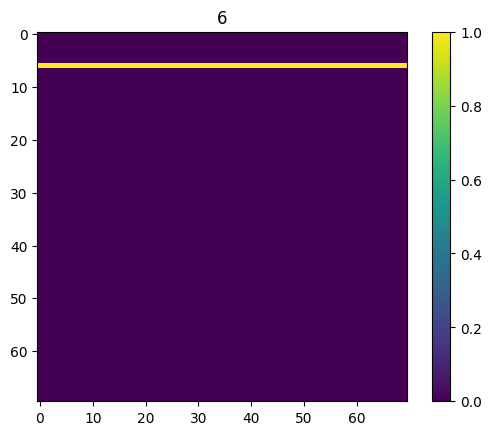

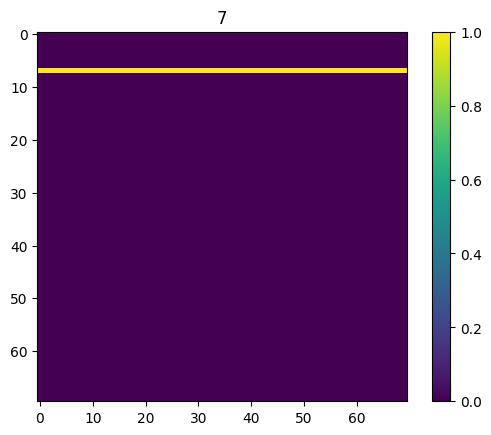

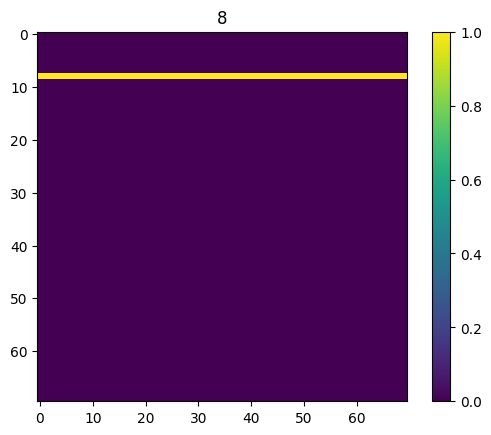

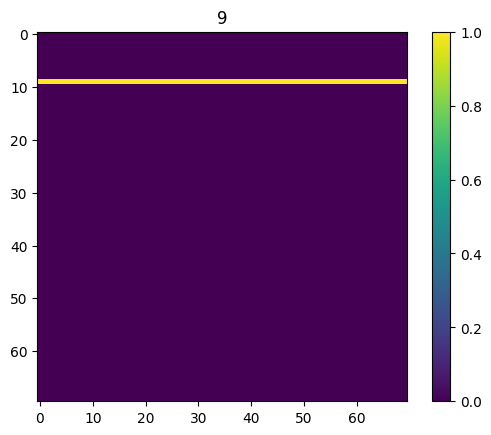

In [151]:
for ii in range(10):#basis_vectors.shape[1]):
    vec = basis_vectors[:,ii]
    vel = copy.deepcopy(d.velocity)
    vel.from_vector(vec)
    plt.figure()
    plt.imshow(cp.asnumpy(vel.data));plt.colorbar();#plt.clim([-3,3])
    plt.title(ii)

Text(0.5, 1.0, 'basis')

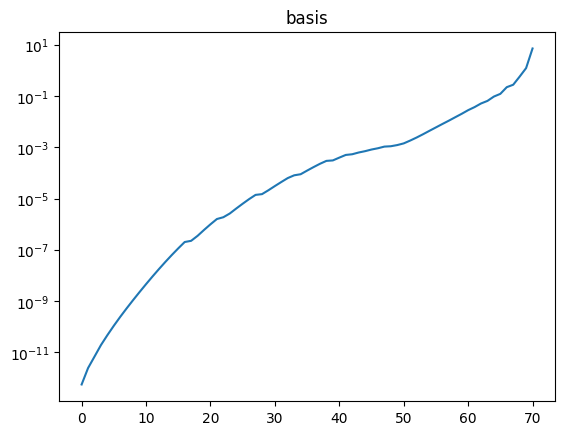

In [152]:
X = J_basis.T@J_basis
w = cp.linalg.eigvalsh(X)   
plt.figure()
plt.semilogy(cp.asnumpy(cp.abs(w)))
plt.title('basis')

In [159]:
kgs.profiling=False
seis_base = seis_forward.vel_to_seis(d.velocity, d.seismogram)[0]
vel_offset_vector = basis_vectors@(cp.array(np.random.default_rng(seed=0).normal(0,1,(basis_vectors.shape[1],1)), dtype=kgs.base_type_gpu))
vel_modified = copy.deepcopy(d.velocity)
vel_modified.from_vector(d.velocity.to_vector() + vel_offset_vector[:,0])
seis_modified = seis_forward.vel_to_seis(vel_modified, d.seismogram)[0]
seis_modified_vector = seis_modified.to_vector()
assert J.flags.c_contiguous
#kgs.rms(seis_modified_vector - seis_base.to_vector() - seis_forward.vel_to_seis_diff(d.velocity, vel_offset_vector.T)), kgs.rms(seis_modified_vector - seis_base.to_vector())
kgs.rms(seis_modified_vector - seis_base.to_vector() - (matmul_part_cpu(J,vel_offset_vector))[:,0]), kgs.rms(seis_modified_vector - seis_base.to_vector())

(array(1.19138132e-05), array(0.00304024))

In [160]:
# So we get access to vel_modified (and seis_modified) and seis_base, and are asked to reconstruct vel_base.
s0 = seis_base.to_vector()[:,None]
s1 = seis_modified.to_vector()[:,None]
v1 = vel_modified.to_vector()[:,None]

lambda_vals = 10**np.linspace(-18,-12,15)
#lambda_vals = [1e-6]
res=[]
v0_list=[]
rhs_part = matmul_efficient(J_basis.T,s0-s1)
delta_v = cp.linalg.solve(J_basis.T@J_basis,rhs_part)
v0 = v1+basis_vectors@delta_v
v0_list.append(v0)
res.append(kgs.rms(v0-d.velocity.to_vector()[:,None]))
res = cp.asnumpy(cp.array(res))
# for lam in lambda_vals:
#     rhs = rhs_part-lam*v1
#     delta_v = cp.linalg.solve( (lam*cp.eye(4901, dtype=JTJ.dtype)+JTJ),rhs)    
#     v0 = v1+delta_v
#     v0_list.append(v0)
#     def penalty(v):
#         delta_v = v-v1
#         res = matmul_part_cpu(J,delta_v)-(s0-s1)
#         vel = copy.deepcopy(d.velocity)
#         vel.from_vector(v[:,0])
#         res_alt = seis_forward.vel_to_seis(vel, d.seismogram)[0].to_vector()[:,None]-s0
#         print(lam*(v.T@v), res.T@res, res_alt.T@res)
#         return lam*(v.T@v)+res.T@res
#     #print('base penalty', penalty(v1))
#     #print('new penalty', penalty(v0))
#     #print('penalty correct', penalty(d.velocity.to_vector()[:,None]))
#     res.append(kgs.rms(v0-d.velocity.to_vector()[:,None]))
# res = cp.asnumpy(cp.array(res))

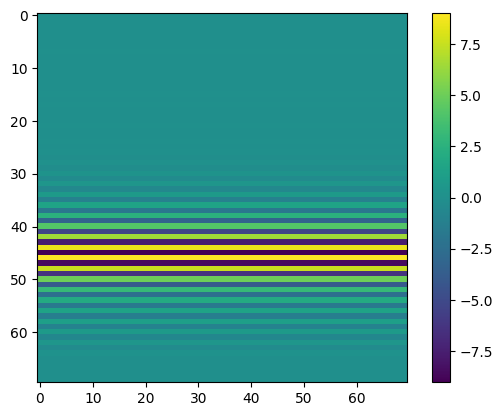

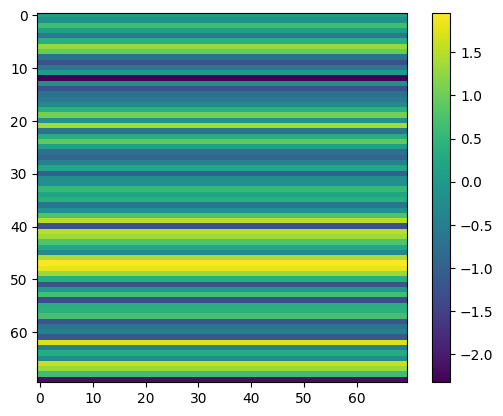

In [161]:
to_take = np.argmin(res)
v0 = v0_list[to_take]
plt.figure()
vel_new = copy.deepcopy(d.velocity)
vel_new.from_vector(v0[:,0])
plt.imshow(cp.asnumpy(vel_new.data-d.velocity.data));plt.colorbar();#plt.clim([-3,3])
plt.figure()
plt.imshow(cp.asnumpy(vel_modified.data-d.velocity.data));plt.colorbar();#plt.clim([-3,3])

In [ ]:
# So we get access to vel_modified (and seis_modified) and seis_base, and are asked to reconstruct vel_base.
s0 = seis_base.to_vector()[:,None]
s1 = seis_modified.to_vector()[:,None]
v1 = vel_modified.to_vector()[:,None]

lambda_vals = 10**np.linspace(-18,-12,15)
#lambda_vals = [1e-6]
res=[]
v0_list=[]
rhs_part = matmul_part_cpu(J.T,s0-s1)
for lam in lambda_vals:
    rhs = rhs_part-lam*v1
    delta_v = cp.linalg.solve( (lam*cp.eye(4901, dtype=JTJ.dtype)+JTJ),rhs)    
    v0 = v1+delta_v
    v0_list.append(v0)
    def penalty(v):
        delta_v = v-v1
        res = matmul_part_cpu(J,delta_v)-(s0-s1)
        vel = copy.deepcopy(d.velocity)
        vel.from_vector(v[:,0])
        res_alt = seis_forward.vel_to_seis(vel, d.seismogram)[0].to_vector()[:,None]-s0
        print(lam*(v.T@v), res.T@res, res_alt.T@res)
        return lam*(v.T@v)+res.T@res
    #print('base penalty', penalty(v1))
    #print('new penalty', penalty(v0))
    #print('penalty correct', penalty(d.velocity.to_vector()[:,None]))
    res.append(kgs.rms(v0-d.velocity.to_vector()[:,None]))
res = cp.asnumpy(cp.array(res))

0.08044403887466642

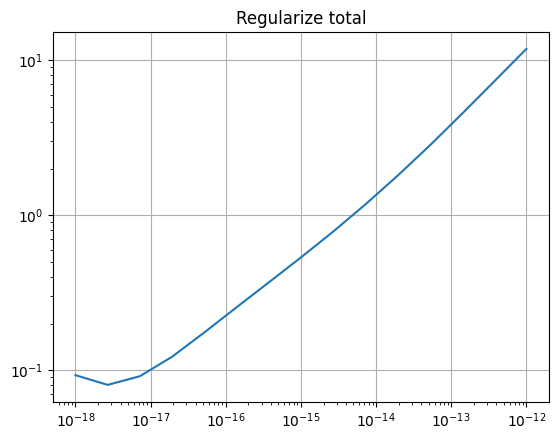

In [118]:
plt.loglog(lambda_vals,res)
plt.grid(True)
plt.title('Regularize total')
np.min(res)

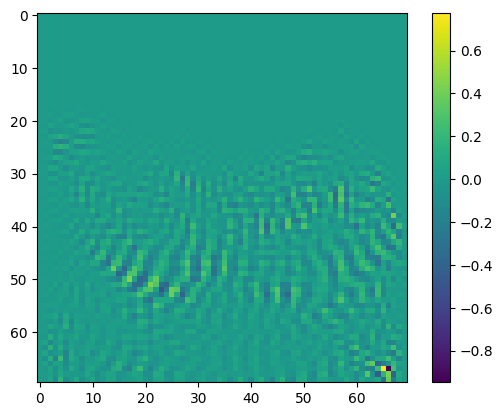

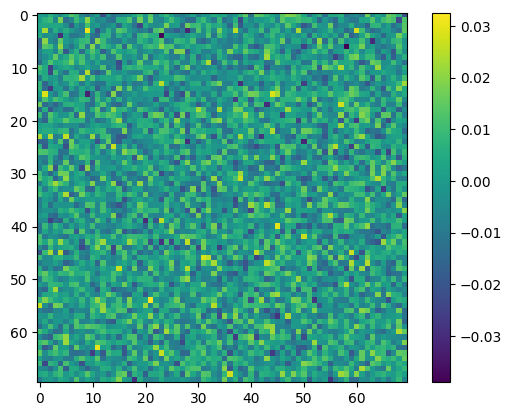

In [119]:
to_take = np.argmin(res)
v0 = v0_list[to_take]
plt.figure()
vel_new = copy.deepcopy(d.velocity)
vel_new.from_vector(v0[:,0])
plt.imshow(cp.asnumpy(vel_new.data-d.velocity.data));plt.colorbar();#plt.clim([-3,3])
plt.figure()
plt.imshow(cp.asnumpy(vel_modified.data-d.velocity.data));plt.colorbar();#plt.clim([-3,3])

In [120]:
# So we get access to vel_modified (and seis_modified) and seis_base, and are asked to reconstruct vel_base.
s0 = seis_base.to_vector()[:,None]
s1 = seis_modified.to_vector()[:,None]
v1 = vel_modified.to_vector()[:,None]

lambda_vals = 10**np.linspace(-17,-7,15)
#lambda_vals = [1e-6]
res=[]
v0_list=[]
rhs_part = matmul_part_cpu(J.T,s0-s1)
for lam in lambda_vals:
    rhs = rhs_part
    delta_v = cp.linalg.solve( (lam*cp.eye(4901, dtype=JTJ.dtype)+JTJ),rhs)    
    v0 = v1+delta_v
    v0_list.append(v0)
    def penalty(v):
        delta_v = v-v1
        res = matmul_part_cpu(J,delta_v)-(s0-s1)
        return lam*(delta_v.T@delta_v)+res.T@res
    #print('base penalty', penalty(v1))
    #print('new penalty', penalty(v0))
    #print('penalty correct', penalty(d.velocity.to_vector()[:,None]))
    res.append(kgs.rms(v0-d.velocity.to_vector()[:,None]))
res = cp.asnumpy(cp.array(res))

0.005986826263337568

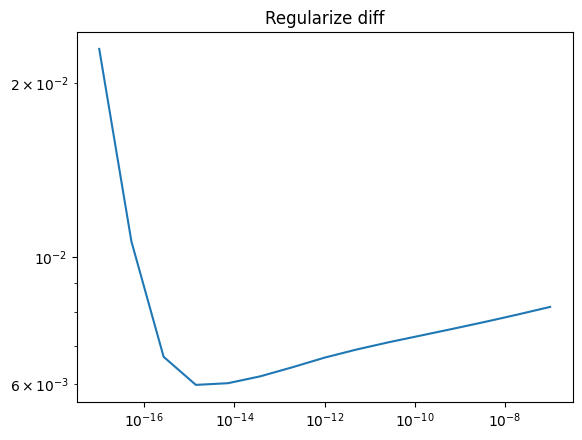

In [121]:
plt.loglog(lambda_vals,res)
plt.title('Regularize diff')
np.min(res)

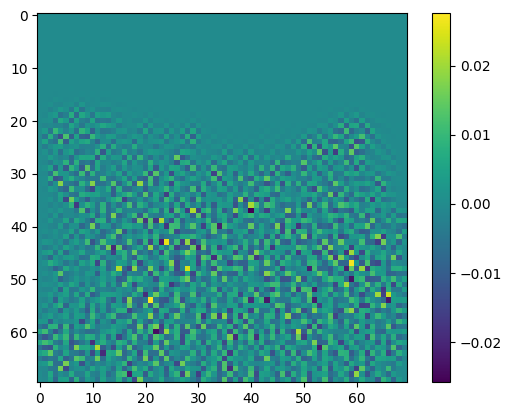

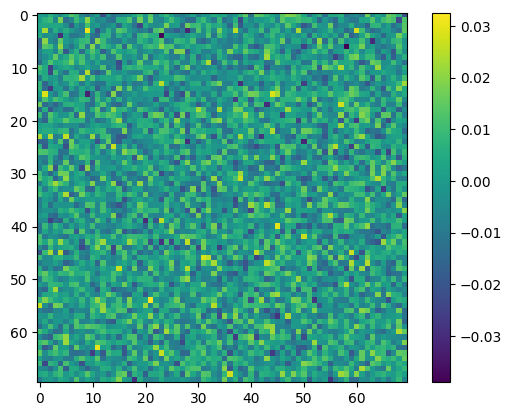

In [122]:
to_take = np.argmin(res)
v0 = v0_list[to_take]
plt.figure()
vel_new = copy.deepcopy(d.velocity)
vel_new.from_vector(v0[:,0])
plt.imshow(cp.asnumpy(vel_new.data-d.velocity.data));plt.colorbar();#plt.clim([-3,3])
plt.figure()
plt.imshow(cp.asnumpy(vel_modified.data-d.velocity.data));plt.colorbar();#plt.clim([-3,3])

In [ ]:
kgs.rms(seis_forward.vel_to_seis(d.velocity).data - 